# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

Now we've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (which is total of 101 classes of food).

Our goal is to beat the original Food101 paper with 10% of the training data, leveraging the power of deep learning.

Our baseline to beat is 50.76% across 101 classes.

In [ ]:
# Check the GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Creating helper functions

In previous notebooks we've created a series of helper functions to help perform various tasks. Let's get them to help in this on, also.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-12 11:54:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-12 11:54:47 (63.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data
Our goal is to beat the original Food101 paper with 10% of the training data so let's download it.and

The data we're downloading comes from the original dataset but has been preprocessed for being able to be used here.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

--2023-02-12 11:55:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   126MB/s    in 19s     

2023-02-12 11:55:22 (82.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images classes are there?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/poutine'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle the test data for prediction analysis



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* A ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer
* Compare our model
* Feature extract for 5 full epochs (validating only on 15% of the test data to save epoch time)

In [ ]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [ ]:
# Setup the base model and freeze it's layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs) # augment images during training phase
x = base_model(x, training=False) # put the base model in inference model so weight which need to stay frozen, do stay frozen
x = layers.GlobalAveragePooling2D(name='glabal_average_pooling')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 glabal_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# Fit the model

initial_epochs = 5

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=initial_epochs,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           validation_steps=int(0.15*len(test_data)),
                                           validation_data=test_data,
                                           callbacks=[checkpoint_callback])

Epoch 1/5


237/237 [==============================] - 133s 488ms/step - loss: 3.4017 - accuracy: 0.2709 - val_loss: 2.5175 - val_accuracy: 0.4407
Epoch 2/5
237/237 [==============================] - 96s 404ms/step - loss: 2.2054 - accuracy: 0.4931 - val_loss: 2.0871 - val_accuracy: 0.4971
Epoch 3/5
237/237 [==============================] - 93s 387ms/step - loss: 1.8339 - accuracy: 0.5628 - val_loss: 1.9038 - val_accuracy: 0.5260
Epoch 4/5
237/237 [==============================] - 88s 367ms/step - loss: 1.6013 - accuracy: 0.6183 - val_loss: 1.8196 - val_accuracy: 0.5334
Epoch 5/5
237/237 [==============================] - 83s 348ms/step - loss: 1.4578 - accuracy: 0.6449 - val_loss: 1.7982 - val_accuracy: 0.5347


In [ ]:
# Evaluate on whole dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 60s 76ms/step - loss: 1.5846 - accuracy: 0.5846


[1.5846046209335327, 0.5846336483955383]

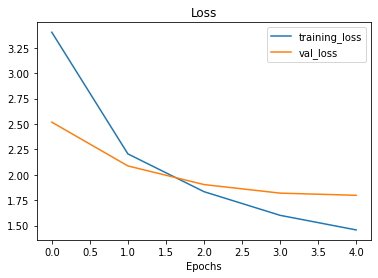

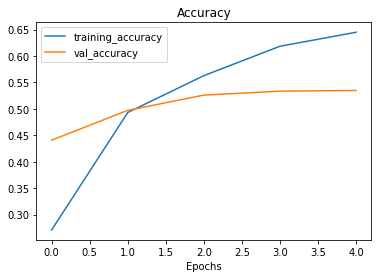

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

>**NOTE**: The curves suggest that the model is overfitting (which means it's learning too well on training data and not generalizing enough to unseen data). This is something we do not want and try to fight with it.

The weapon of choice may be something like fine tuning...


## Fine tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last five
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (typically 10x less when fine tutning)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered 10 times
              metrics=['accuracy'])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
glabal_average_pooling True
output_layer True


In [ ]:
# Check whihc layers are trainable in base_model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Fine-tunign for 5 epochs

fine_tune_epochs = 10 # total number of epochs we're after (5+5)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1],
                                                     steps_per_epoch=len(train_data_all_10_percent),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     )

Epoch 5/10


237/237 [==============================] - 94s 350ms/step - loss: 1.2044 - accuracy: 0.6869 - val_loss: 1.7284 - val_accuracy: 0.5543
Epoch 6/10
237/237 [==============================] - 79s 333ms/step - loss: 1.0945 - accuracy: 0.7089 - val_loss: 1.7347 - val_accuracy: 0.5524
Epoch 7/10
237/237 [==============================] - 81s 340ms/step - loss: 1.0207 - accuracy: 0.7328 - val_loss: 1.7542 - val_accuracy: 0.5461
Epoch 8/10
237/237 [==============================] - 78s 326ms/step - loss: 0.9479 - accuracy: 0.7452 - val_loss: 1.7328 - val_accuracy: 0.5546
Epoch 9/10
237/237 [==============================] - 77s 323ms/step - loss: 0.8832 - accuracy: 0.7640 - val_loss: 1.7196 - val_accuracy: 0.5530
Epoch 10/10
237/237 [==============================] - 75s 315ms/step - loss: 0.8365 - accuracy: 0.7721 - val_loss: 1.7301 - val_accuracy: 0.5524


In [ ]:
# Evaluate on whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 58s 73ms/step - loss: 1.4827 - accuracy: 0.6075


[1.4826805591583252, 0.6074851751327515]

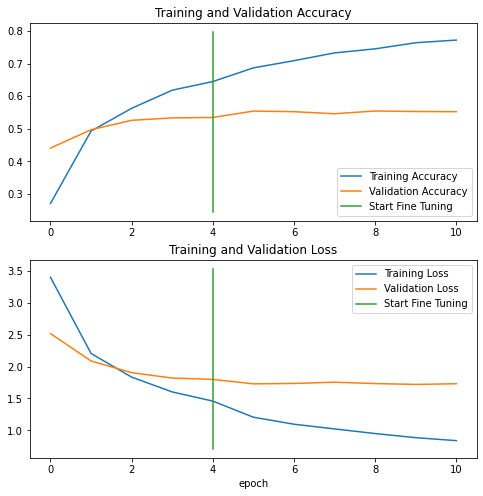

In [ ]:
# Compare histories
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use model in external application, it has to be saved somewhere...

In [ ]:
#%tensorflow_version 2.9

In [ ]:
# Saving th fine tuned model
# model.save
#model.save('drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_saved', overwrite=True)

TypeError: ignored

In [ ]:
 # Load and evaluate the model
loaded_model = tf.keras.models.load_model('drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_saved')

ValueError: ignored

In [ ]:
# Evaluate loaded model and compare the performance to presaved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

In [ ]:
all_classes_10_percent_fine_tune_results

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the most wrong.

In [ ]:
import tensorflow as tf

# Download pretrained model, that was pretrained earlier
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-02-12 11:55:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   119MB/s    in 0.4s    

2023-02-12 11:55:54 (119 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
# Unzip data and get it ready
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [ ]:
# Load in saved model
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [ ]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 88s 99ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [ ]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # Set verbosity to see how long is left

790/790 [==============================] - 2099s 3s/step


In [ ]:
len(pred_probs)

25250

In [ ]:
# What's the shape of prediction 
pred_probs.shape

(25250, 101)

In [ ]:
# First 10 predictions
pred_probs[:10]

array([[5.9542067e-02, 3.5742048e-06, 4.1376896e-02, ..., 1.4138652e-09,
        8.3530831e-05, 3.0897569e-03],
       [9.6401680e-01, 1.3753220e-09, 8.4780413e-04, ..., 5.4287149e-05,
        7.8362204e-12, 9.8465835e-10],
       [9.5925879e-01, 3.2533680e-05, 1.4866935e-03, ..., 7.1891486e-07,
        5.4397424e-07, 4.0276045e-05],
       ...,
       [4.7313309e-01, 1.2931172e-07, 1.4805557e-03, ..., 5.9750077e-04,
        6.6968969e-05, 2.3469342e-05],
       [4.4571940e-02, 4.7265320e-07, 1.2258494e-01, ..., 6.3498710e-06,
        7.5318612e-06, 3.6778918e-03],
       [7.2438931e-01, 1.9249691e-09, 5.2310974e-05, ..., 1.2291421e-03,
        1.5792678e-09, 9.6395437e-05]], dtype=float32)

In [ ]:
# The probability array
pred_probs[0]

array([5.95420673e-02, 3.57420481e-06, 4.13768962e-02, 1.06605957e-09,
       8.16142798e-09, 8.66396554e-09, 8.09271967e-07, 8.56525787e-07,
       1.98591097e-05, 8.09776793e-07, 3.17277427e-09, 9.86735472e-07,
       2.85322982e-04, 7.80488951e-10, 7.42300879e-04, 3.89163033e-05,
       6.47404886e-06, 2.49773507e-06, 3.78912046e-05, 2.06783270e-07,
       1.55384078e-05, 8.15071758e-07, 2.62305684e-06, 2.00106854e-07,
       8.38276890e-07, 5.42159296e-06, 3.73909620e-06, 1.31505322e-08,
       2.77615618e-03, 2.80519707e-05, 6.85622836e-10, 2.55749037e-05,
       1.66889440e-04, 7.64072861e-10, 4.04528371e-04, 1.31506841e-08,
       1.79573601e-06, 1.44482851e-06, 2.30628774e-02, 8.24670053e-07,
       8.53658491e-07, 1.71386273e-06, 7.05254342e-06, 1.84020976e-08,
       2.85534270e-07, 7.94834523e-06, 2.06815321e-06, 1.85251878e-07,
       3.36196422e-08, 3.15225829e-04, 1.04109422e-05, 8.54484426e-07,
       8.47418606e-01, 1.05554454e-05, 4.40947048e-07, 3.74042502e-05,
      

In [ ]:
len(pred_probs[0]), sum(pred_probs[0])

(101, 1.000000051688104)

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the `predict()` method.

In [ ]:
# We get one prediction probability per clss (we have 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like: {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {tf.argmax(pred_probs[0])}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: [5.95420673e-02 3.57420481e-06 4.13768962e-02 1.06605957e-09
 8.16142798e-09 8.66396554e-09 8.09271967e-07 8.56525787e-07
 1.98591097e-05 8.09776793e-07 3.17277427e-09 9.86735472e-07
 2.85322982e-04 7.80488951e-10 7.42300879e-04 3.89163033e-05
 6.47404886e-06 2.49773507e-06 3.78912046e-05 2.06783270e-07
 1.55384078e-05 8.15071758e-07 2.62305684e-06 2.00106854e-07
 8.38276890e-07 5.42159296e-06 3.73909620e-06 1.31505322e-08
 2.77615618e-03 2.80519707e-05 6.85622836e-10 2.55749037e-05
 1.66889440e-04 7.64072861e-10 4.04528371e-04 1.31506841e-08
 1.79573601e-06 1.44482851e-06 2.30628774e-02 8.24670053e-07
 8.53658491e-07 1.71386273e-06 7.05254342e-06 1.84020976e-08
 2.85534270e-07 7.94834523e-06 2.06815321e-06 1.85251878e-07
 3.36196422e-08 3.15225829e-04 1.04109422e-05 8.54484426e-07
 8.47418606e-01 1.05554454e-05 4.40947048e-07 3.74042502e-05
 3.53062278e-05 3.24890061e-05 6.73147370e-0

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred classes do we have
len(pred_classes)

25250

Now we've got predictions array of all of our model's predictions. Now to evaluate them we need to compare them to the original test dataset labels.

In [ ]:
# Test data is now batched...
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Because we want the index value of the '1' in the tensor

# Look at the first 10
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Unraveling the batched data is done, however there is one thing that's really important to remember. We **DID NOT** shuffle the test data at the beginning, during the batching phase, so now we can unbatch it in the same order so our predictions will match the initial order of test images. Therefore we'll be able to easily compare them to eachother.

## Evaluating our model's predictions

One way to check that our model's predictions is in the same order is to find the accuracy score.

In [ ]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [ ]:
# Let's try scikit-learn's accuracy score and see what's the result
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metric come close to our model's evaluate() results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [ ]:
# Difference between results
results_downloaded_model[1]-sklearn_accuracy

2.0097978059574473e-08

## Let's get visual - creating confusion matrix

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

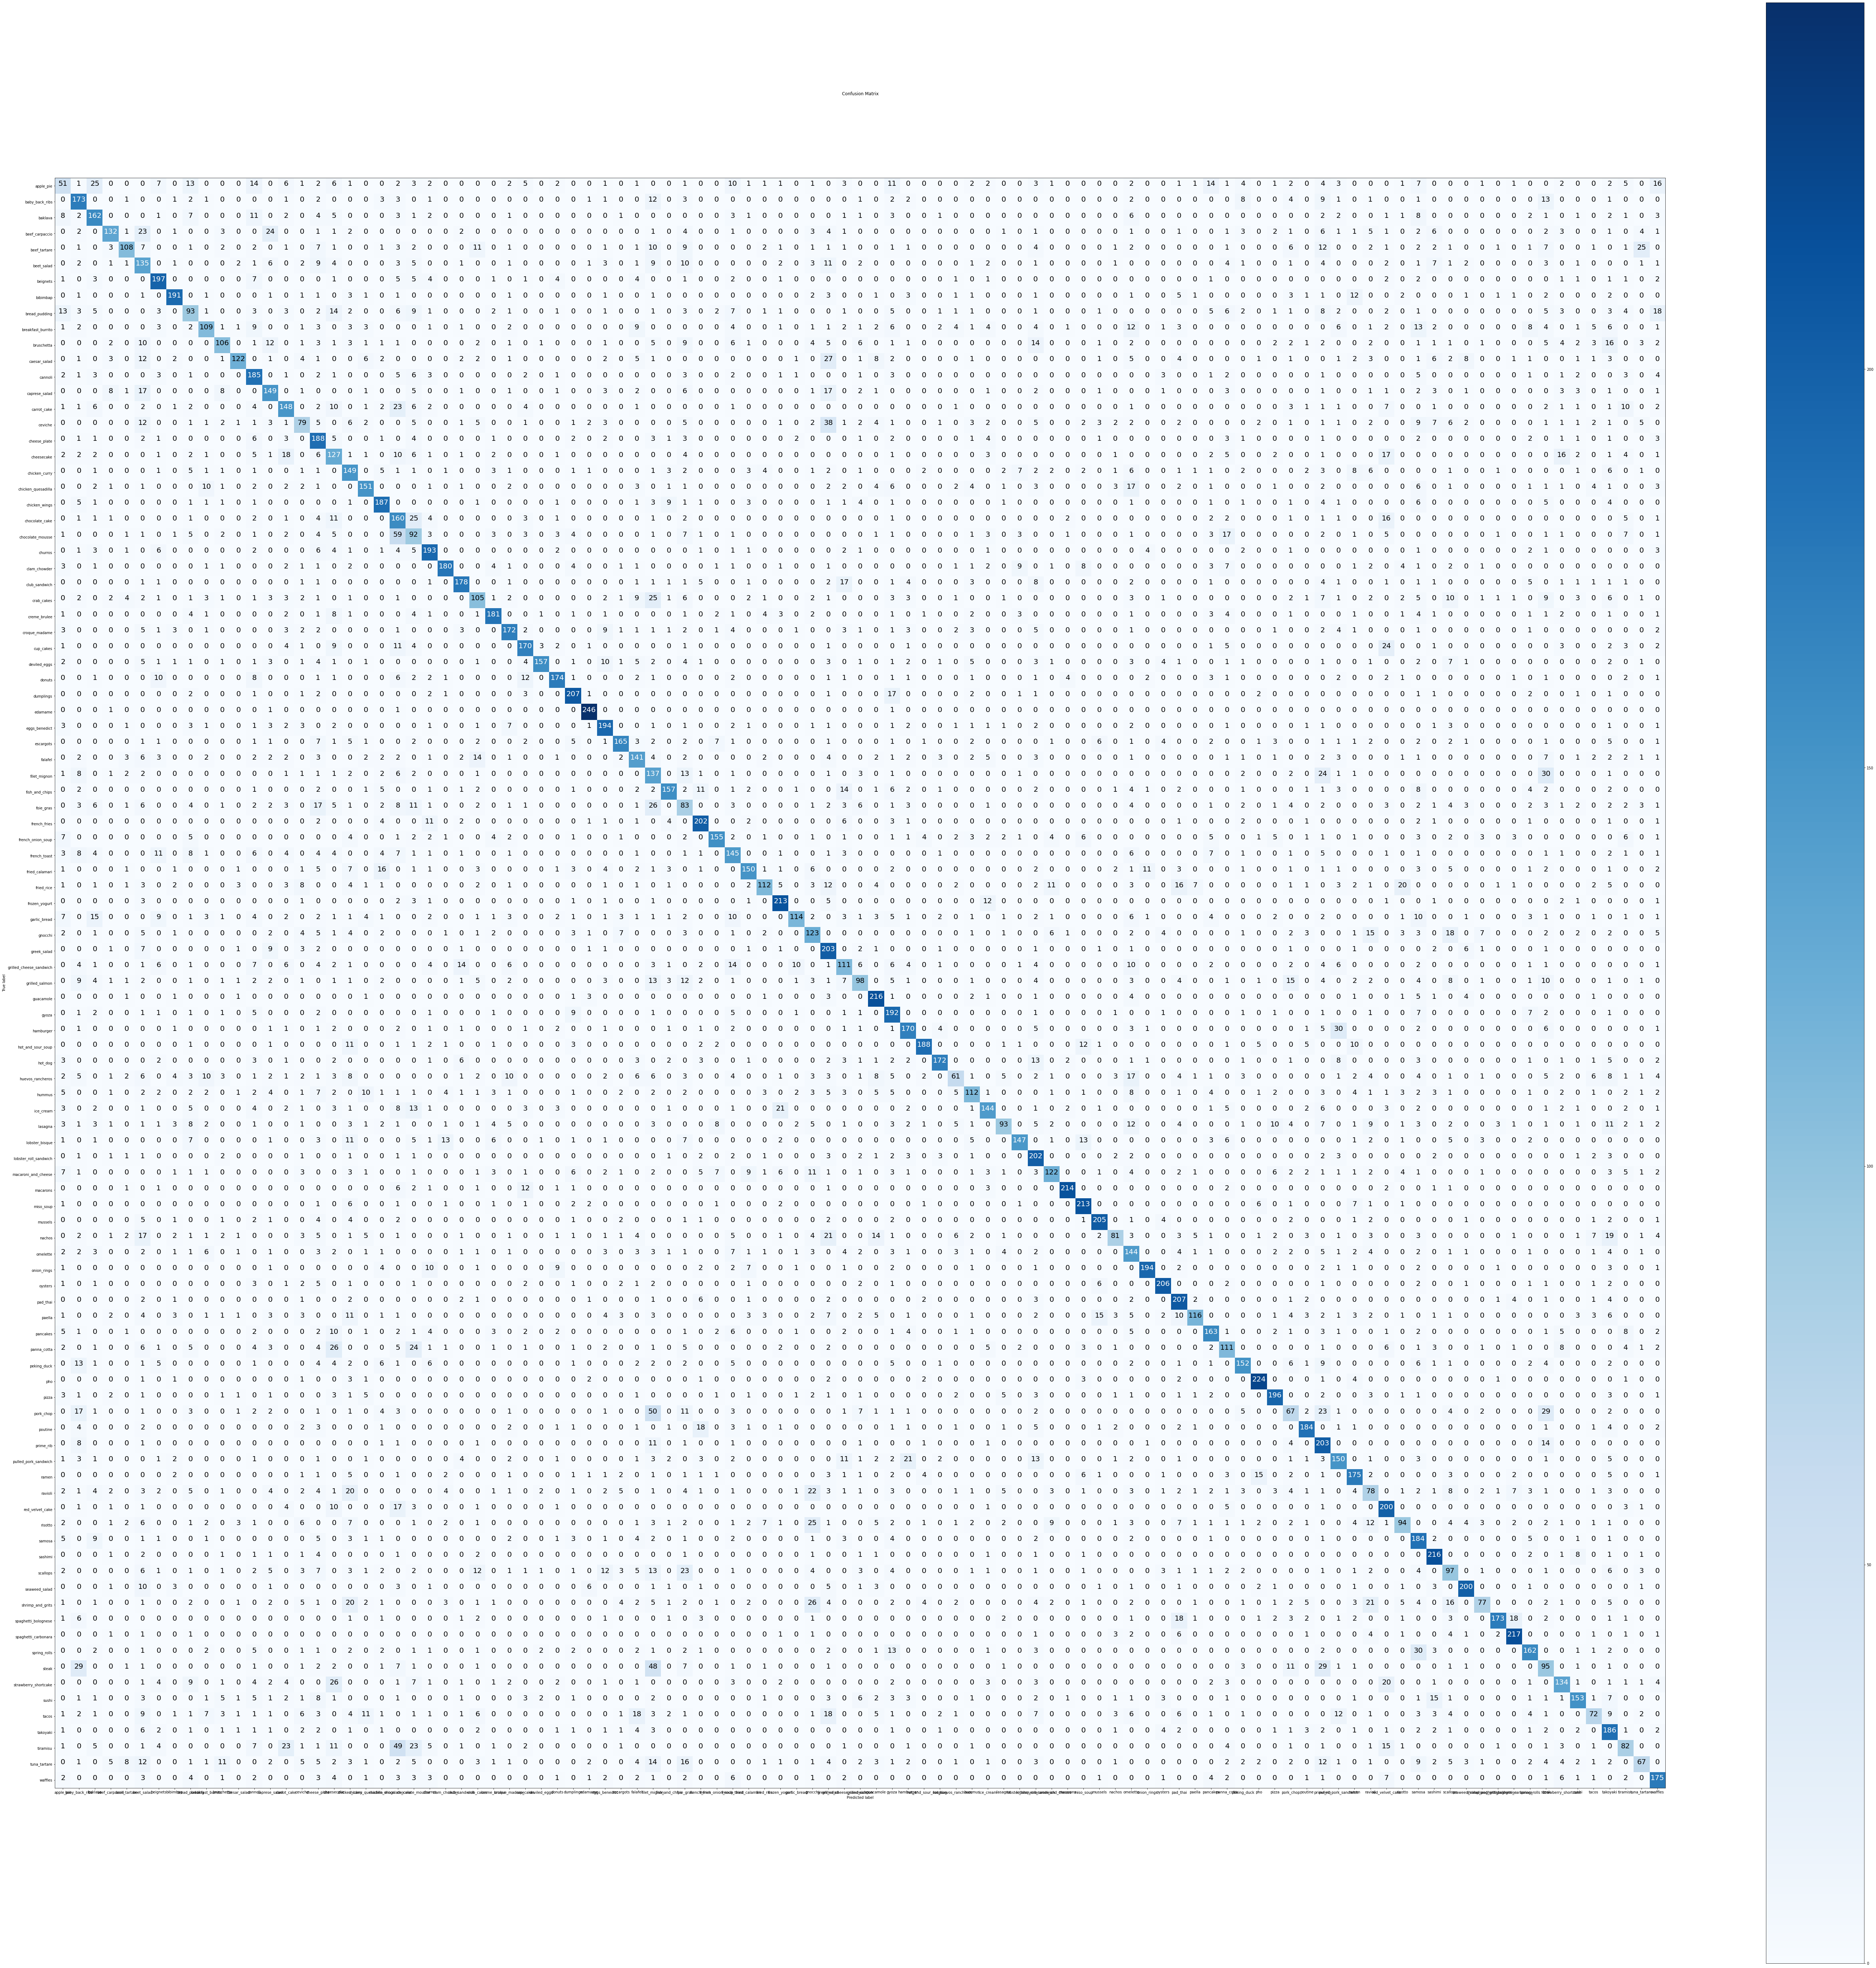

In [ ]:
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


# We need to make some changes to our conf matrix so x labels are vertical

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

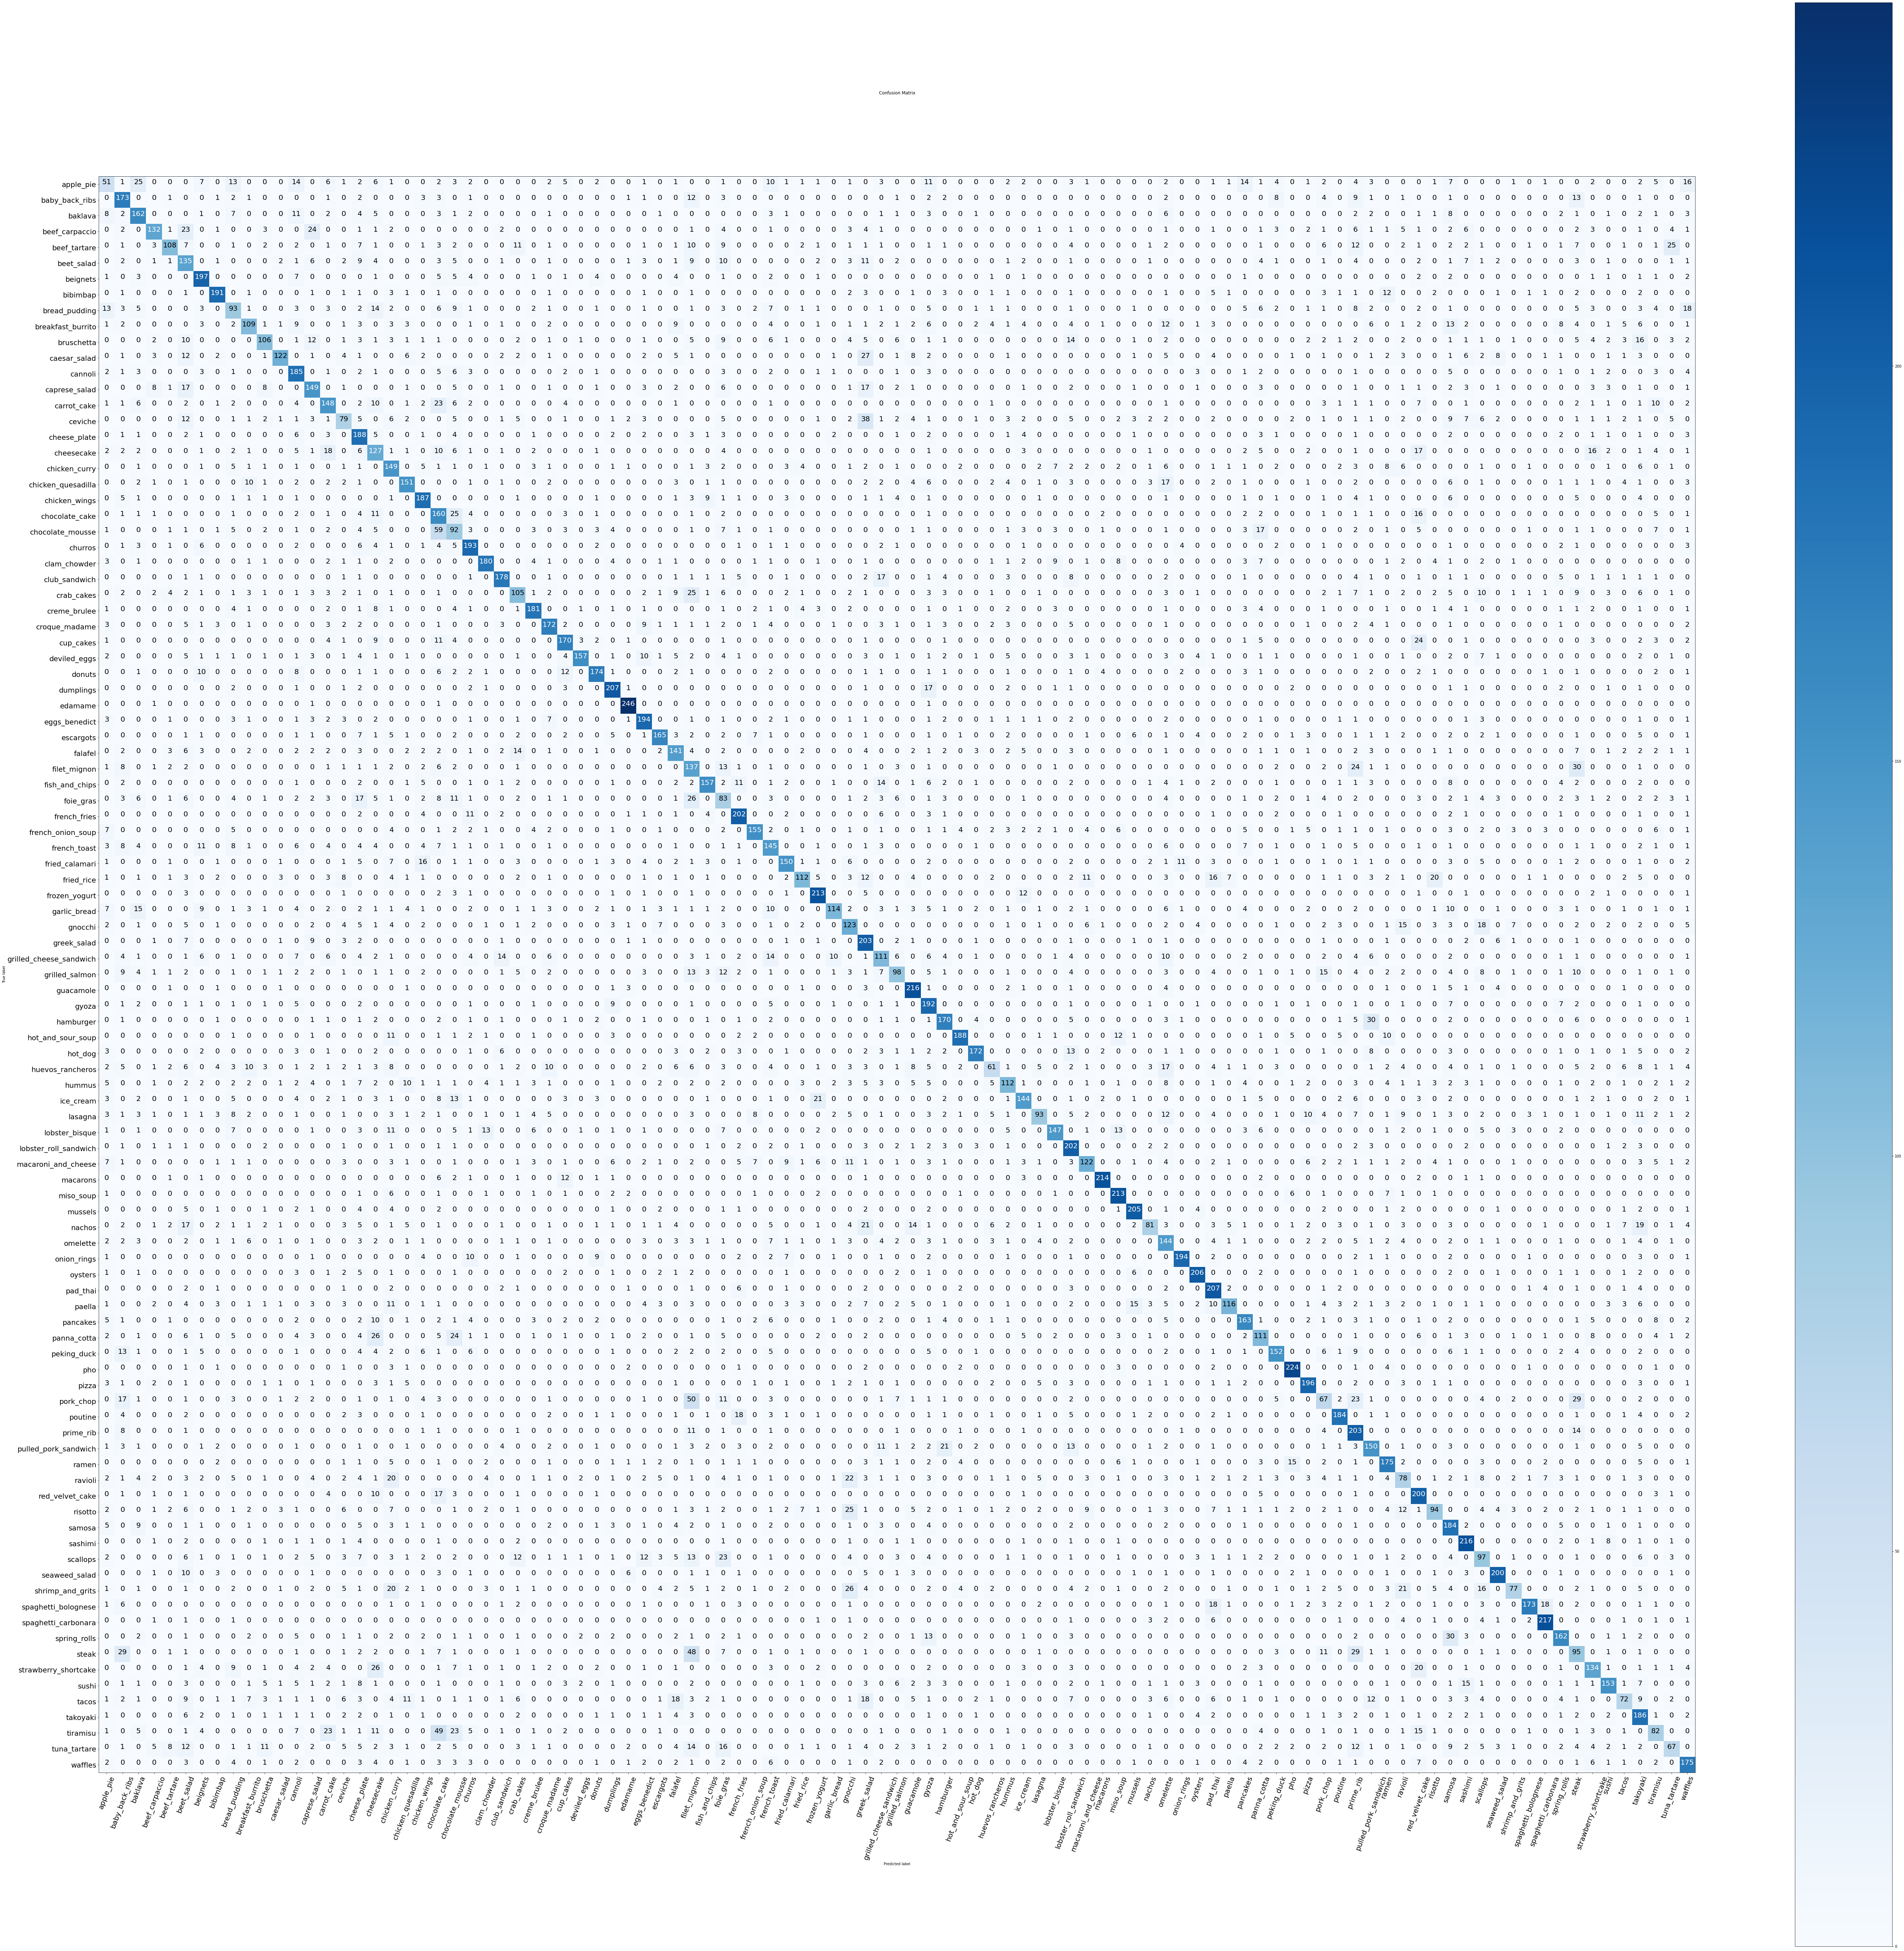

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (precision, recall and F1). Let's try it out :)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

Numbers above give great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [ ]:
# Get a dictionary of classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [ ]:
class_names[70]

'pad_thai'

Let's plot all our our classes F1 scores!

In [ ]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification_report_items
for k, v in classification_report_dict.items():
  if k == 'accuracy': # stop one we get to accuracy 
    break
  else:
    # Add class names and F1 scores to empty dictionary
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn F1 scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores.head(10)

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

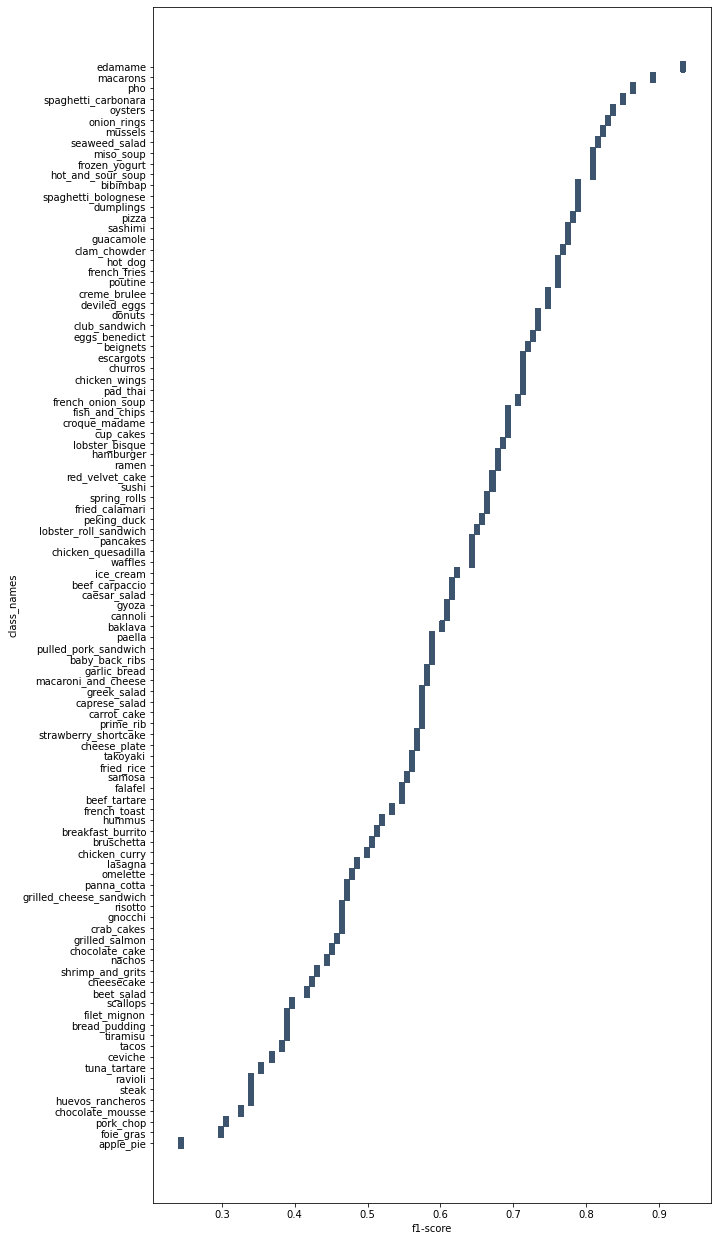

In [ ]:
# Horizontal bar chart
import seaborn as sns
plt.figure(figsize=(10,22))
sns.histplot(x='f1-score', 
             y='class_names', 
             bins=len(f1_scores), 
             data=f1_scores,
             element='poly')

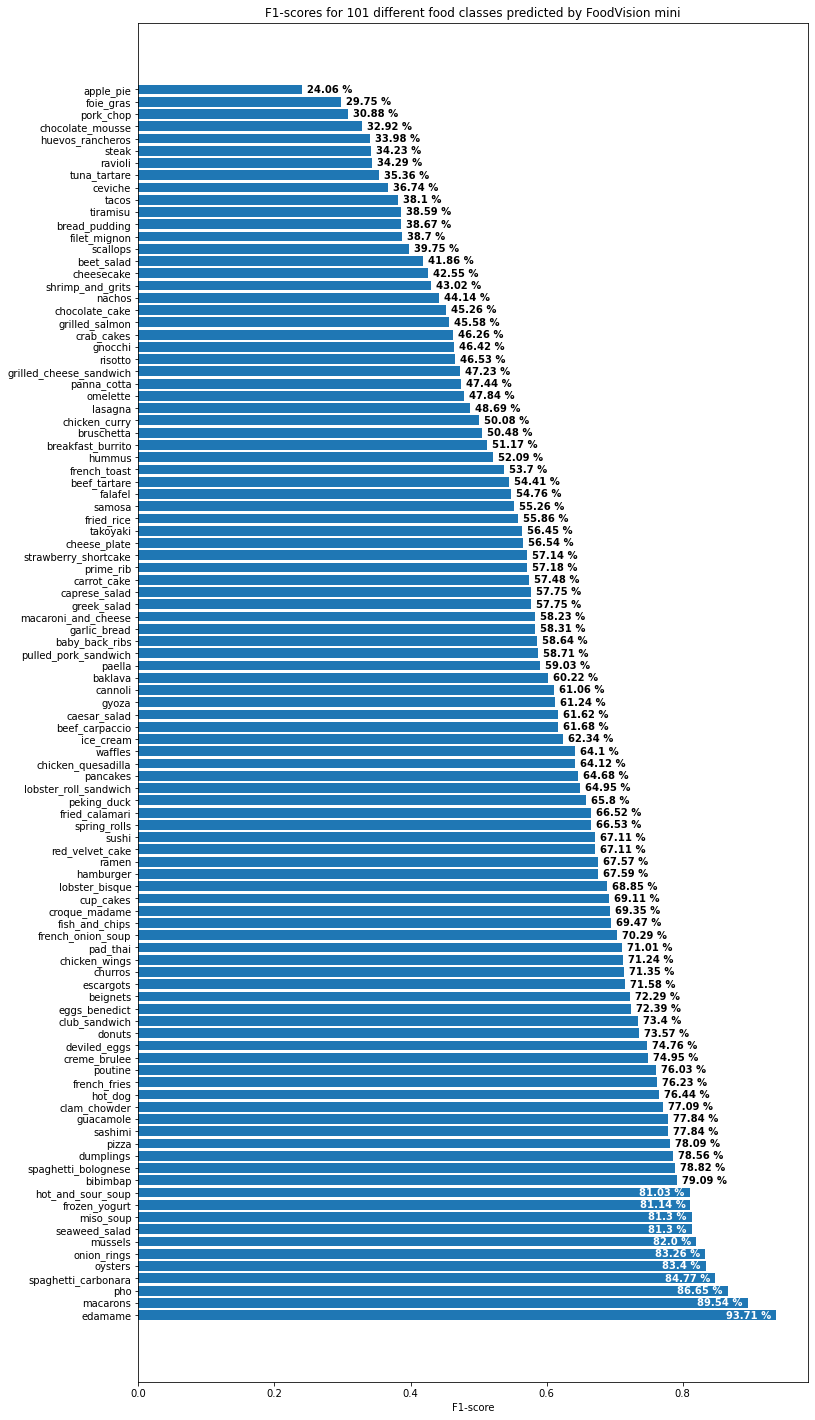

In [ ]:
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values) # Get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-score')
ax.set_title('F1-scores for 101 different food classes predicted by FoodVision mini')

# Adding the annotations at the end of each bar with values

for score in scores:
  # Rectangle widths are already integer-valued byt are floating
  # type, so it helps to remove the trailing decimal point and 0
  # by converting to int type
  width = score.get_width()

  # Creating a percentile value to be added
  value_percentile = str(round(score.get_width()*100, 2)) + " %"

  # If value is smaller than 0.8 (80%), it can be added at the end
  if width < 0.8:
    xloc = 5
    clr = 'black'
    align = 'left'

  # If the value is greater, it should be added inside the bar
  else:
    xloc = -5
    clr = 'white'
    align = 'right'

  # Locating the middle of the bar
  yloc = score.get_y() + score.get_height() / 2

  # Adding the labels/annotations
  label = ax.annotate(value_percentile,
                      xy=(width, yloc),
                      xytext=(xloc,0),
                      textcoords='offset points',
                      ha=align,
                      va='center',
                      color=clr,
                      weight='bold',
                      clip_on=True)

## Visualizing predictions on test images

Now, this is the real test - how does our model go on food images not even in out test dataset (images of our own).

To visualize our model predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a Tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [ ]:
# Create a function to load and prepeare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into 
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to the image
    img_shape (int): height/width dimensions of target image size
    scale (bool): scale pixel values from 0-225 to 0-1 or not
  
  Returns:
    Image Tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale?
  if scale:
    # Rescale the image to get all valeus between 0 and 1
    return img/255.
  
  else:
    return img # Don't need to rescale for EfficientNet models in TensorFlow

Now we can load and prepare images with the function above. Let's write some code to visialize images, their target labels and our model's predictions.

Specifically we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the load images
3. Plot the original images with the model's predictions, prediction probability and truth label

1/1 [==============================] - 0s 97ms/step


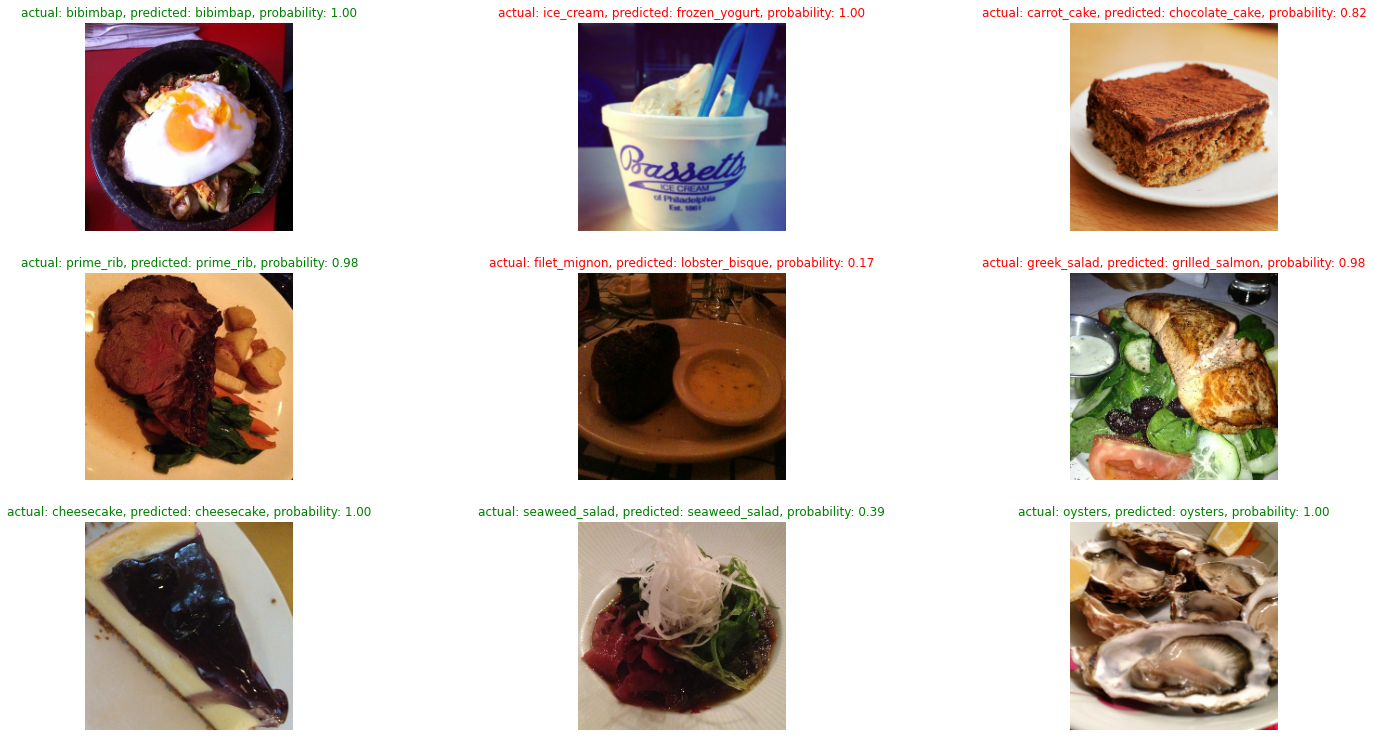

In [ ]:
# Make predictions on a series of random images
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(25,13))
for i in range(9):

  # Choose a random image from a random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded) # get the prediction probability array
  pred_class = class_names[pred_prob.argmax()] # get the index of highest probability and match it to class_names list
  
  # Plot the images
  plt.subplot(3, 3, i+1)
  plt.imshow(img/255.) # normalize the images for matplotlib

  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = 'g'
  else:
    title_color = 'r'

  plt.title(f"actual: {class_name}, predicted: {pred_class}, probability: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image filepaths in the test dataset using `list_files()`
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where truth does not match the predictions)
4. Sort the DataFrame based on the wrong predcitions (have the highest prediction probabilities at the top)
5. Visualize the images with the highest prediction probabilities but have the wrong prediction

In [ ]:
# 1. Get all of the image filepaths in the test dataset
filepaths = []
for filepath in test_data.list_files('101_food_classes_10_percent/test/*/*.jpg', 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred': pred_classes,
                        'pred_conf': pred_probs.max(axis=1),
                        'y_true_classname': [class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes]})

pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501945          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [116]:
# 3. Find our in our DataFrame which predictions are wrong
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_classname      y_pred_classname  pred_correct  
0       0.847418        apple_pie                 gyoza         False  
1       0.964017        apple_pie             apple_pie          True  
2       0.959259        apple_pie             apple_pie          True  
3       0.658607        apple_pie  pulled_pork_sandwich         False  
4       0.367901        apple_pie             prime_rib         False  
...          ...              ...                   ...           ...  
25245   0.972823          waffles               waffles          True  
25246   0.878028          waffles          cheese_plate         False  
25247   0.537899          waffles               waffles          True  
25248   0.501945          waffles  strawberry_shortcake         False  
25249   0.690629          waffles               waffles          True  

[25250 rows x 7 columns]

In [117]:
# 4. Sort our DataFrame to have most wrong predictions on top
top_100_wrong = pred_df[pred_df['pred_correct']==False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4       5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95      86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999903               pancakes               omelette         False  
11642   0.999878           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999817              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

b'101_food_classes_10_percent/test/chocolate_mousse/1685320.jpg'
b'101_food_classes_10_percent/test/french_toast/2872314.jpg'
b'101_food_classes_10_percent/test/cheesecake/2332717.jpg'
b'101_food_classes_10_percent/test/fish_and_chips/109120.jpg'
b'101_food_classes_10_percent/test/hot_dog/3844876.jpg'
b'101_food_classes_10_percent/test/cheesecake/996516.jpg'
b'101_food_classes_10_percent/test/hummus/732504.jpg'
b'101_food_classes_10_percent/test/apple_pie/2298195.jpg'
b'101_food_classes_10_percent/test/ramen/766615.jpg'


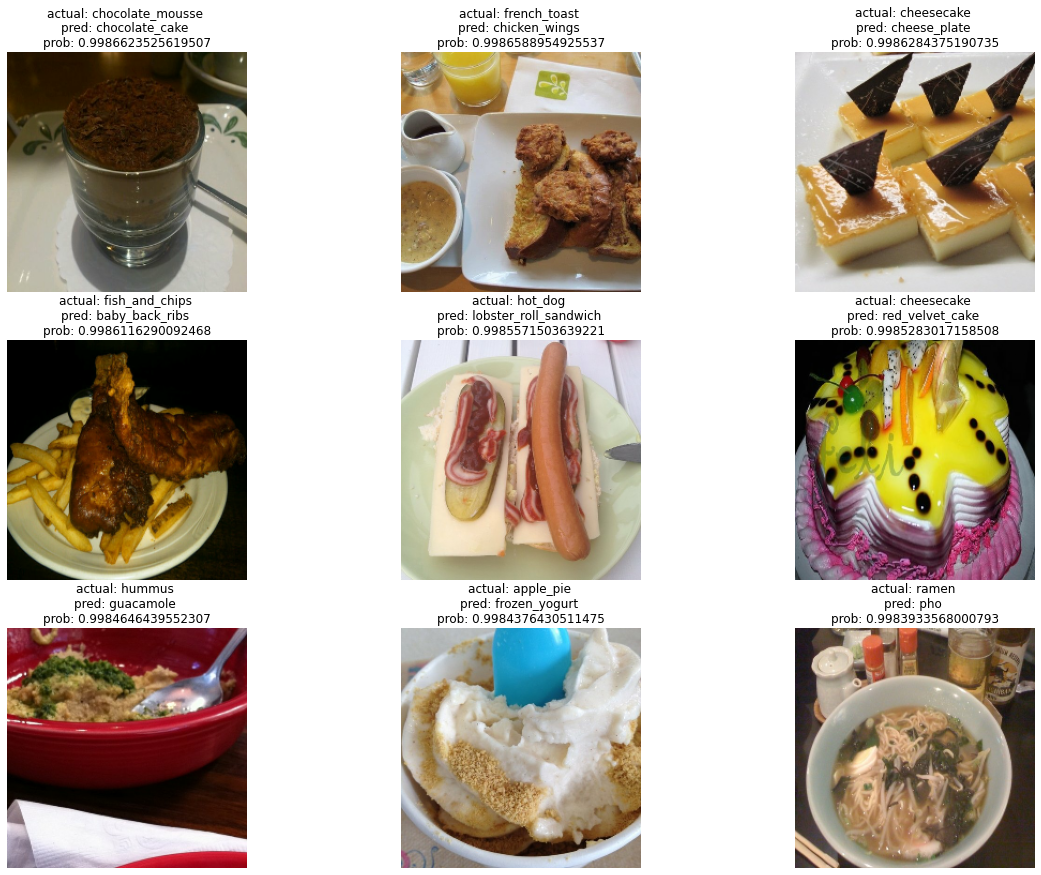

In [122]:
# 5. Visualizing - Daniel's method
images_to_view = 9
start_index = 50

plt.figure(figsize=(20, 15))

for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  print(row[1])
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters in each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname} \npred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)

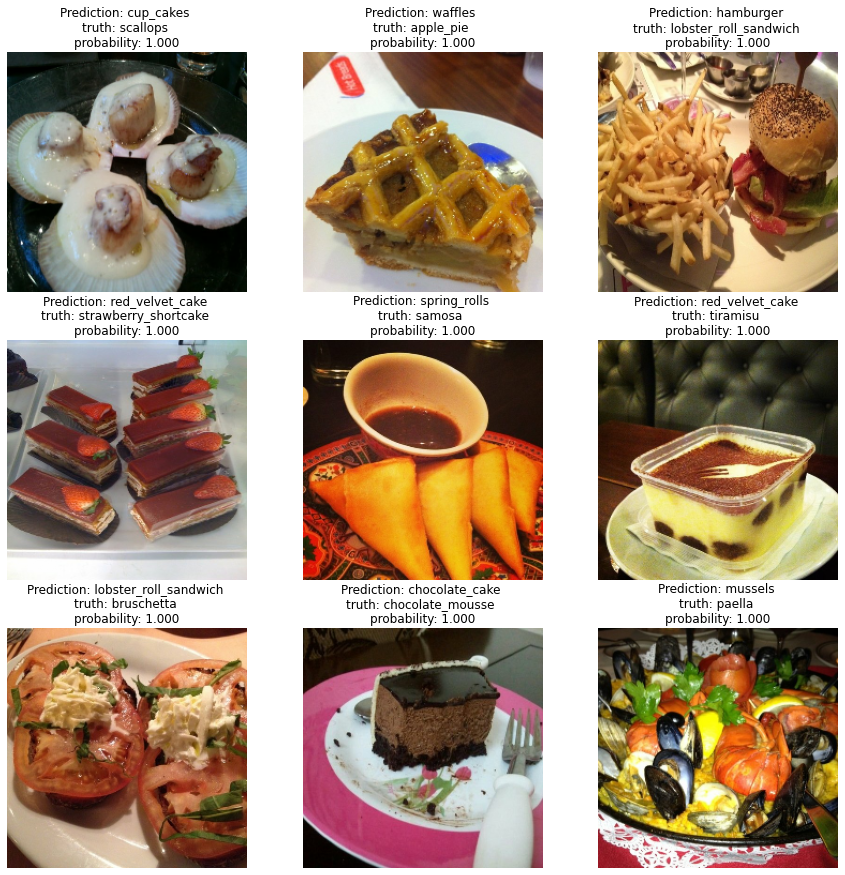

In [114]:
# 5. Visualize the test data samples that are wrong but have high probability of prediction
import matplotlib.pyplot as plt
import numpy as np

top_100_wrong.reset_index(inplace=True)

plt.figure(figsize=(15,15))

for i in range(9):
  # Load in the data
  fpath = top_100_wrong['img_path'][i].decode()
  img = load_and_prep_image(fpath, scale=False)

  # Plot the images
  plt.subplot(3, 3, i+1)  
  plt.imshow(img/255.)
  plt.title(f"Prediction: {top_100_wrong['y_pred_classname'][i]} \ntruth: {top_100_wrong['y_true_classname'][i]} \nprobability: {top_100_wrong['pred_conf'][i]:.3f}")
  plt.axis(False)

## Testing our big dog model on own, custom images

In [156]:
# Getting images from the internet
def get_image_net():
  import requests # request img from web
  import shutil # save img locally

  url = input('Please enter an image URL (string):') #prompt user for img url
  file_name = input('Save image as (string):') #prompt user for file_name

  res = requests.get(url, stream = True)

  if res.status_code == 200:
      with open(file_name,'wb') as f:
        shutil.copyfileobj(res.raw, f)
      print('Image sucessfully Downloaded: ',file_name)
  else:
      print('Image Couldn\'t be retrieved')

  return file_name

1/1 [==============================] - 0s 129ms/step
tf.Tensor(
[[[8.3179271e-01 8.5532212e-01 9.0238094e-01]
  [8.0076164e-01 8.2429105e-01 8.7129009e-01]
  [7.8719246e-01 8.1072187e-01 8.5778075e-01]
  ...
  [4.3860370e-01 2.4848887e-01 1.5608798e-01]
  [5.9431618e-01 3.2782462e-01 1.3993487e-01]
  [4.9010855e-01 2.3146008e-01 7.4241660e-05]]

 [[7.2562701e-01 7.4915642e-01 7.9621524e-01]
  [8.0656528e-01 8.3009470e-01 8.7715352e-01]
  [9.3939096e-01 9.6292037e-01 9.7532934e-01]
  ...
  [4.6532169e-01 2.0323771e-01 1.4722784e-01]
  [4.7882420e-01 2.9045764e-01 1.1045937e-01]
  [4.5895234e-01 2.7842888e-01 4.7097377e-02]]

 [[6.5765548e-01 6.8118489e-01 7.2824371e-01]
  [7.2679847e-01 7.5032789e-01 7.9738677e-01]
  [8.3430851e-01 8.5783792e-01 9.0489674e-01]
  ...
  [4.5401725e-01 1.3796413e-01 0.0000000e+00]
  [4.1525766e-01 1.5533994e-01 3.0725101e-02]
  [7.2326970e-01 4.6805468e-01 3.0281428e-01]]

 ...

 [[2.9387477e-01 3.1348261e-01 3.8799241e-01]
  [2.6258457e-01 2.8219244e-01 3

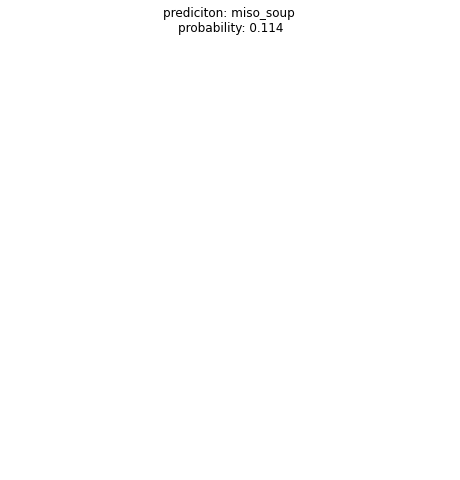

In [155]:
# Get custom image to predict on

image = get_image_net()
# Load in the image
image = 'steak.jpg'
img = load_and_prep_image(image)

# Get the prediction
img_expanded = tf.expand_dims(img, axis=0)
pred_prob = model.predict(img_expanded)
pred_class = class_names[pred_prob.argmax()]

# Plotting the image
plt.figure(figsize=(8,8))
#plt.imshow(img)
plt.title(f"prediciton: {pred_class} \nprobability: {pred_prob.max():.3f}")
plt.axis(False)

print(img)
print(pred_prob)
print(pred_class)
